# MLFlow plugin tutorial
This notebook shows to use the MLFlow plugin for Hamilton. The first three sections present minimal examples to introduce the core functionalities:
1. Training and saving a model with `MLFlowModelSaver`
2. Loading a model for inference with `MLFlowModelLoader`
3. Automatically tracking execution results with `MLFlowTracker`

The following sections give details about individual features.   

Load the [notebook extension](https://github.com/DAGWorks-Inc/hamilton/tree/main/examples/jupyter_notebook_magic) for Hamilton. It allows us to define a dataflow in a code cell.

In [1]:
%load_ext hamilton.plugins.jupyter_magic

## 1. Training and saving a model

### 1.1 Define
We define a simple dataflow that loads the titanic dataset and trains a logistic regression to predict survival. The function parameters specify the dependencies between nodes of the dataflow.

The first line of the cell `%%cell_to_module model_training --display` is related to the notebook extension and means this cell will define a self-contained Python module named `model_training`

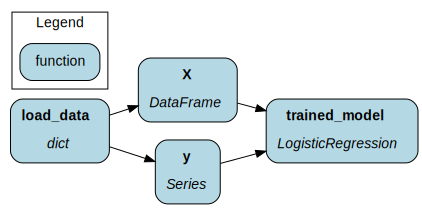

In [2]:
%%cell_to_module model_training --display
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from hamilton.function_modifiers import extract_fields

# split the returned dictionary into 2 nodes: `X` and `y`
@extract_fields(dict(X=pd.DataFrame, y=pd.Series))
def load_data() -> dict:
    """Load the titanic dataset and split it in X and y. 
    Only keep the columns `fare` and `age` and fill null values.
    """
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    X = X[["fare", "age"]].fillna(0)
    return dict(X=X, y=y)

def trained_model(X: pd.DataFrame, y: pd.Series) -> LogisticRegression:
    """Fit a binary classifier on the data"""
    model = LogisticRegression()
    model.fit(X, y)
    return model

### 1.2 Assemble
To execute code, we build the `Driver` with the module `model_training` defined in the previous cell. 

The statement `to.mlflow()` creates a `MLFlowModelSaver` that registers the model returned by `trained_model()` as `my_predictor` in the MLFlow model registry. We add this to the `Driver` using
`.with_materializers()`. A new node will be displayed in the visualization

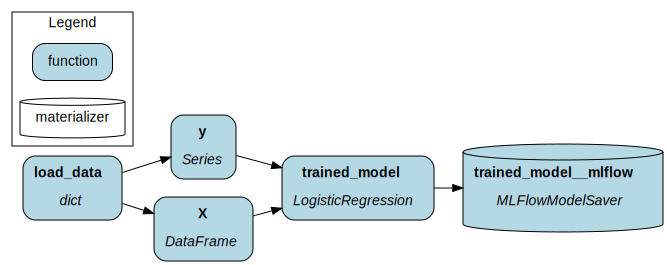

In [3]:
from hamilton import driver
from hamilton.io.materialization import to

model_saver = to.mlflow(
    id="trained_model__mlflow",  # name given to the saver
    dependencies=["trained_model"],  # node returning the model
    register_as="my_predictor",  # name of the model in the MLFlow registry
)

dr = (
    driver.Builder()
    .with_modules(model_training)
    .with_materializers(model_saver)
    .build()
)
dr

In [4]:
# see the full API
from hamilton.plugins.mlflow_extensions import MLFlowModelSaver
MLFlowModelSaver?

Init signature:
MLFlowModelSaver(
    path: Union[str, pathlib.Path] = 'model',
    register_as: Optional[str] = None,
    flavor: Optional[str] = None,
    run_id: Optional[str] = None,
    kwargs: Dict[str, Any] = None,
) -> None
Docstring:     
Save model to the MLFlow tracking server using `.log_model()`

:param path: Run relative path to store model. Will constitute the model URI.
:param register_as: If not None, register the model under the specified name.
:param flavor: Library format to save the model (sklearn, xgboost, etc.). Automatically inferred if None.
:param run_id: Log model to a specific run. Leave to `None` if using the `MLFlowTracker`
:param kwargs: Arguments for `.log_model()`. Can be flavor-specific.
File:           ~/projects/dagworks/hamilton/hamilton/plugins/mlflow_extensions.py
Type:           ABCMeta
Subclasses:     

### 1.3 Execute
We execute our dataflow by calling `Driver.execute()` and requesting node names. Requesting `trained_model` will train the model and return it. Requesting `trained_model__mlflow` will train the model, save it, and return metadata. We then visualize the execution path 

Registered model 'my_predictor' already exists. Creating a new version of this model...
Created version '8' of model 'my_predictor'.


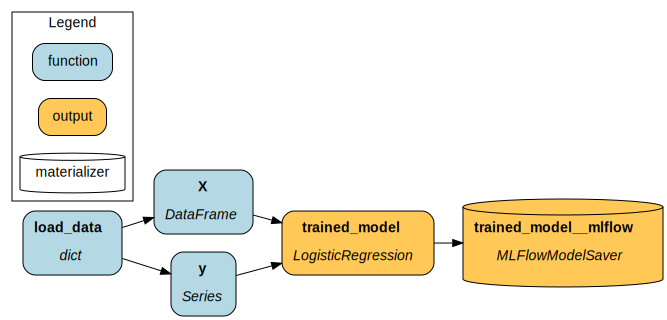

In [5]:
results = dr.execute(["trained_model", "trained_model__mlflow"])
dr.visualize_execution(["trained_model", "trained_model__mlflow"])

In [6]:
# we can inspect the model metadata
results["trained_model__mlflow"]

{'artifact_path': 'model',
 'flavors': {'python_function': {'model_path': 'model.pkl',
   'predict_fn': 'predict',
   'loader_module': 'mlflow.sklearn',
   'python_version': '3.11.1',
   'env': {'conda': 'conda.yaml', 'virtualenv': 'python_env.yaml'}},
  'sklearn': {'pickled_model': 'model.pkl',
   'sklearn_version': '1.5.0',
   'serialization_format': 'cloudpickle',
   'code': None}},
 'model_uri': 'runs:/30c106f0915d43fda9f5974fb36cdc39/model',
 'model_uuid': '860cc1ea405d461d8c58db4b68d25158',
 'run_id': '30c106f0915d43fda9f5974fb36cdc39',
 'saved_input_example_info': None,
 'signature_dict': None,
 'signature': None,
 'utc_time_created': '2024-06-11 15:01:30.896479',
 'mlflow_version': '2.13.2',
 'metadata': None,
 'registered_model': {'name': 'my_predictor',
  'version': 8,
  'creation_time': 1718118092290,
  'last_updated_timestamp': 1718118092290,
  'description': None,
  'user_id': None,
  'current_stage': 'None',
  'source': 'file:///home/tjean/projects/dagworks/hamilton/examp

## 2. Model Inference Dataflow

### 2.1 Define
We define a simple dataflow that uses a trained model to make predictions on user inputs. Parameters that point to no other functions (e.g, `user_input`) are called "inputs" as you see on the visualization.

We annotate `model: BaseEstimator` to allow any scikit-learn model to be passed.

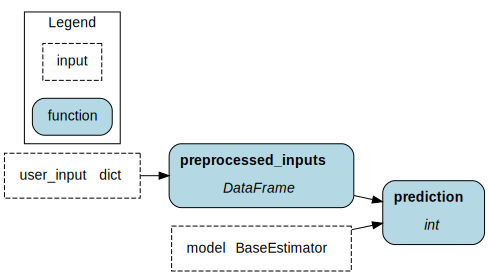

In [7]:
%%cell_to_module model_inference --display
import pandas as pd
from sklearn.base import BaseEstimator

def preprocessed_inputs(user_input: dict) -> pd.DataFrame:
    df = pd.DataFrame(user_input, index=[0])
    return df

def prediction(preprocessed_inputs: pd.DataFrame, model: BaseEstimator) -> int:
    return model.predict(preprocessed_inputs)

### 2.2 Assemble
Again, we create a `Driver`, but this time we use `from_.mlflow()` to create a `MLFlowModelLoader` that looks for model `my_predictor` in the MLFlow registry. We pass this object through `.with_materializers()`

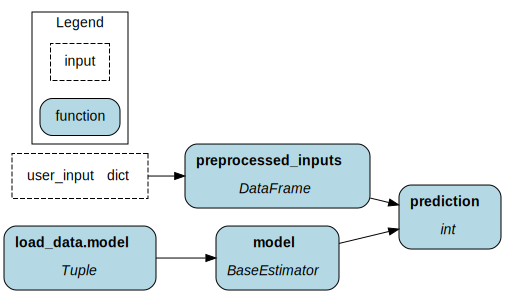

In [8]:
from hamilton import driver
from hamilton.io.materialization import from_

model_loader = from_.mlflow(
    target="model",
    mode="registry",
    model_name="my_predictor",
    version=1,
)

dr = (
    driver.Builder()
    .with_modules(model_inference)
    .with_materializers(model_loader)
    .build()
)
dr

In [9]:
# see the full API
from hamilton.plugins.mlflow_extensions import MLFlowModelLoader
MLFlowModelLoader?

Init signature:
MLFlowModelLoader(
    model_uri: Optional[str] = None,
    mode: Literal['tracking', 'registry'] = 'tracking',
    run_id: Optional[str] = None,
    path: Union[str, pathlib.Path] = 'model',
    model_name: Optional[str] = None,
    version: Union[str, int, NoneType] = None,
    version_alias: Optional[str] = None,
    flavor: Optional[str] = None,
    kwargs: Dict[str, Any] = None,
) -> None
Docstring:     
Load model from the MLFlow tracking server or model registry using .load_model()
You can pass a model URI or the necessary metadata to retrieve the model

:param model_uri: Model location starting as `runs:/` for tracking or `models:/` for registry
:param mode: `tracking` or registry`. tracking needs `run_id` and `path`. registry needs `model_name` and `version` or `version_alias`.
:param run_id: Run id of the model on the tracking server
:param path: Run relative path where the model is stored
:param model_name: Name of the registered model (equivalent to `registe

### 2.3 Execute
We simulate user inputs that match the `fare` and `age` columns of the training data. Then, we request `prediction` and `load_data.model` to return the loaded model.

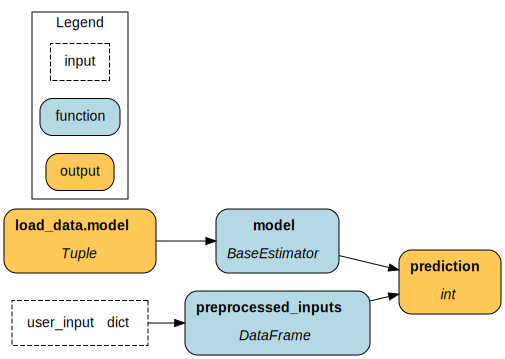

In [10]:
inputs = dict(user_input={"fare": 10.72, "age": 48})

results = dr.execute(["prediction", "load_data.model"], inputs=inputs)
dr.visualize_execution(["prediction", "load_data.model"], inputs=inputs)

In [11]:
# we can inspect the prediction
# load_data.model returns a tuple (model, model metadata)
print(results["prediction"])
results["load_data.model"]

['0']


(LogisticRegression(),
 {'artifact_path': 'model',
  'flavors': {'python_function': {'env': {'conda': 'conda.yaml',
     'virtualenv': 'python_env.yaml'},
    'loader_module': 'mlflow.sklearn',
    'model_path': 'model.pkl',
    'predict_fn': 'predict',
    'python_version': '3.11.1'},
   'sklearn': {'code': None,
    'pickled_model': 'model.pkl',
    'serialization_format': 'cloudpickle',
    'sklearn_version': '1.5.0'}},
  'model_uri': 'models:/my_predictor/1',
  'model_uuid': '5cfda7f11ed440e6823c13a99dc47471',
  'run_id': '8099b8e575d04476b47960431d17f9f5',
  'saved_input_example_info': None,
  'signature_dict': None,
  'signature': None,
  'utc_time_created': '2024-06-10 22:43:07.254057',
  'mlflow_version': '2.13.2',
  'metadata': None})

## 3. MLFlowTracker
So far, we saved and loaded models, but the MLFlow metadata is almost empty. By adding the `MLFlowTracker()`, we can automatically track run configurations, metrics, figures, and other artifacts.

### 3.1 Define
We define a slightly more complex pipeline that splits the dataset into training and test sets. Then, we compute the model performance on each set and produce a scatter plot of features and correct/incorrect predictions.

Notice that no `mlflow` statements is needed in our dataflow definition.

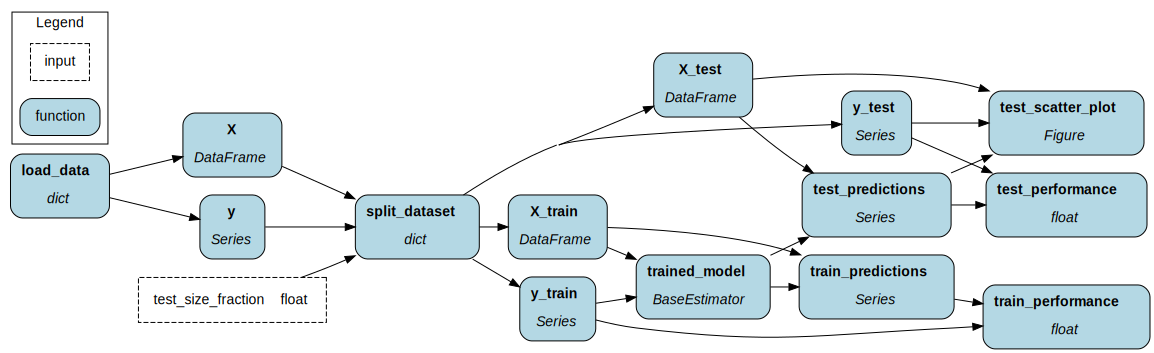

In [12]:
%%cell_to_module model_training_2 --display
import pandas as pd
import matplotlib.figure
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from hamilton.function_modifiers import extract_fields


@extract_fields(dict(X=pd.DataFrame, y=pd.Series))
def load_data() -> dict:
    """Load the titanic dataset and split it in X and y. 
    Only keep the columns `fare` and `age` and fill null values.
    """
    X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
    X = X[["fare", "age"]].fillna(0)
    return dict(X=X, y=y)


@extract_fields(dict(
    X_train=pd.DataFrame, y_train=pd.Series,
    X_test=pd.DataFrame, y_test=pd.Series,
))
def split_dataset(
    X: pd.DataFrame,
    y: pd.Series,
    test_size_fraction: float = 0.3
) -> dict:
    """Partition the dataset into training and testing sets."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size_fraction,
    )
    return dict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

def trained_model(X_train: pd.DataFrame, y_train: pd.Series) -> BaseEstimator:
    """Binary classifier fitted on the training data"""
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

def train_predictions(trained_model: BaseEstimator, X_train: pd.DataFrame) -> pd.Series:
    return trained_model.predict(X_train)

def train_performance(y_train: pd.Series, train_predictions: pd.Series) -> float:
    """Balanced accuracy on the training set"""
    return balanced_accuracy_score(y_train, train_predictions)

def test_predictions(trained_model: BaseEstimator, X_test: pd.DataFrame) -> pd.Series:
    return trained_model.predict(X_test)

def test_performance(y_test: pd.Series, test_predictions: pd.Series) -> float:
    """Balanced accuracy on the training set"""
    return balanced_accuracy_score(y_test, test_predictions)

def test_scatter_plot(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    test_predictions: pd.Series,
) -> matplotlib.figure.Figure:
    """Scatter plot of fare and age with colors for correct/incorrect predictions"""
    correctly_predicted = y_test == test_predictions
    feature_1 = X_test.iloc[:, 0]
    feature_2 = X_test.iloc[:, 1]

    fig = plt.figure()
    plt.scatter(feature_1, feature_2, c=correctly_predicted)
    return fig

### 3.2 Assemble
This code is just like Section #1.2, but we add a `MLFlowTracker()` to the `Driver` by passing it to `.with_materializers()`. This objects accepts many arguments to set the right tracking and registry server, specify the experiment names, and set other metadata. Generally, the defaults are sufficient if you're developing locally. 

In [13]:
from hamilton import driver
from hamilton.io.materialization import to
from hamilton.plugins.h_mlflow import MLFlowTracker

dr = (
    driver.Builder()
    .with_modules(model_training_2)
    .with_adapters(MLFlowTracker())
    .with_materializers(
        to.mlflow(
            id="trained_model__mlflow",
            dependencies=["trained_model"],
            register_as="my_new_model",
        ),
    )
    .build()
)

In [14]:
MLFlowTracker?

Init signature:
MLFlowTracker(
    tracking_uri: Optional[str] = None,
    registry_uri: Optional[str] = None,
    artifact_location: Optional[str] = None,
    experiment_name: str = 'Hamilton',
    experiment_tags: Optional[dict] = None,
    experiment_description: Optional[str] = None,
    run_id: Optional[str] = None,
    run_name: Optional[str] = None,
    run_tags: Optional[dict] = None,
    run_description: Optional[str] = None,
    log_system_metrics: bool = False,
)
Docstring:      Driver adapter logging Hamilton execution results to an MLFlow server.
Init docstring:
Configure the MLFlow client and experiment for the lifetime of the tracker

:param tracking_uri: Destination of the logged artifacts and metadata. It can be a filesystem, database, or server. [reference](https://mlflow.org/docs/latest/getting-started/tracking-server-overview/index.html)
:param registry_uri: Destination of the registered models. By default it's the same as the tracking destination, but they can be d

### 3.3 Execute
Like before, we request nodes for execution. But this time, all requested nodes will be logged in MLFlow, not just model savers! Inputs and other metadata will also be automatically available (see next section for details)

Registered model 'my_new_model' already exists. Creating a new version of this model...
Created version '6' of model 'my_new_model'.


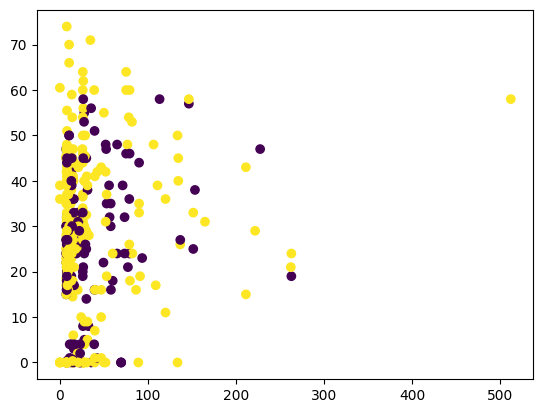

In [15]:
results = dr.execute(
    ["trained_model__mlflow", "train_performance", "test_performance", "test_scatter_plot"],
    inputs=dict(test_size_fraction=0.3)
)

## 4. Feature list
A list of included features and cool things possible with the MLFlow plugin (in no particular order).

1. Automatically tracks `.execute(inputs=...)` and `Builder().with_config()` as MLFlow params. This creates columns that you can use to filter runs in the UI.

2. The run tag `code_version` is automatically added by the `MLFlowTracker`. This allows you to know exactly what code was executed and group runs that use the same code, but vary in terms of inputs. 

3. Store the entire `HamiltonGraph` as an artifact `hamilton_graph.json`. This contains the source code of the executed dataflow.

4. Automatically log `plotly` and `matplotlib` figures as `.png` artifacts. For more control, you can use the `to.plotly()` and `to.plt()` savers. Notably, this allows you to save interactive plotly visualizations as HTML. 

5. Use the `MLFlowTracker` to specify experiment metadata and run metadata that will help you browse the MLFlow UI and programatic search. `experiment_description` and `run_description` accept markdown strings.

    ```python
    MLFlowTracker(
        experiment_name=...,
        experiment_description=...,
        run_name=...,
        run_tags=...,
        run_description=...,
    )
    ```

6. The tags specified using the Hamilton decorator `@tag` on the model-producing function are stored in the MLFlow model registry
    ```python
    import pandas as pd
    from hamilton.function_modifiers import tag
    from sklearn.linear_model import LogisticRegression

    @tag(team="forecast", feature_set="v3")
    def trained_model(X_train: pd.DataFrame, y_train: pd.Series) -> LogisticRegression:
        """Fit a binary classifier on the training data"""
        model = LogisticRegression()
        model.fit(X_train, y_train)
        return model

    # ...

    to.mlflow(
        id="trained_model__mlflow",
        dependencies=["trained_model"],
        register_as="new_algo",
    ),
    ```

7. Use the `MLFlowTracker` with the `HamiltonTracker`. You can link the two by matching:

    - `experiment_name` == `project_id`; You can manually create an `experiment_id`, but you can set its name.
    - `run_name` == `dag_name`; You can have multiple MLFlow runs with the same name

    ```python
    from hamilton import driver
    from hamilton.io.materialization import to
    from hamilton.plugins.h_mlflow import MLFlowTracker
    from hamilton_sdk.adapters import HamiltonTracker

    project_id = 3
    dag_name = "titanic_classifier_training"

    dr = (
        driver.Builder()
        .with_modules(model_training_2)
        .with_adapters(
            MLFlowTracker(
                experiment_name=f"hamilton-project-{project_id}",
                run_name=dag_name,
            ),
            HamiltonTracker(
                username="my_username",
                project_id=project_id,
                dag_name=dag_name,
            )
        )
        .with_materializers(
            to.mlflow(
                id="trained_model__mlflow",
                dependencies=["trained_model"],
                register_as="my_new_model",
            ),
        )
        .build()
    )
    ```

8. Log model performance with nested runs (e.g., cross-validation, hyperparameter tuning). This will require adding `mlflow` code in your dataflow definition though.
    ```python
    import mlflow
    from sklearn.model_selection import KFold

    def model_cross_validation(X: pd.DataFrame, y: pd.Series):
        kfold = KFold(n_splits=3)

        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

            model = LogisticRegression()
            model.fit(X_train, y_train)

            test_pred = model.predict(X_test)
            score = balanced_accuracy(y_test, test_pred)

            with mlflow.start_run(nested=True):
                mlflow.log_metric("balanced_accuracy", score)
                # ... could log plots, hyperparams, etc.
    ```
